In [0]:
#모듈 import
import tensorflow as tf
import numpy as np

import os
import shutil

In [2]:
#데이터 내려받기
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  54.7M      0  0:00:14  0:00:14 --:--:-- 58.4M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [3]:
#폴더 이동과 하위 폴더 이름 가져오기

os.chdir('PetImages')
!ls

Cat  Dog


In [4]:
#파일 확인해보기.
print(os.listdir('Cat')[:5])
print(os.listdir('Dog')[:5])

['5735.jpg', '5479.jpg', '5968.jpg', '457.jpg', '11355.jpg']
['5735.jpg', '5479.jpg', '5968.jpg', '457.jpg', '11355.jpg']


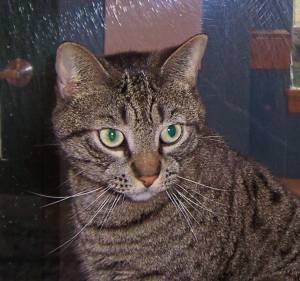

In [5]:
#이미지 꺼내보기
from IPython.display import Image
Image(filename='Cat/1.jpg')

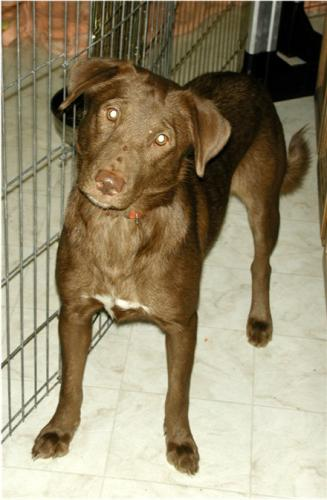

In [6]:
Image(filename='Dog/1.jpg')

# 데이터 전처리 <1>
잘 못 인코딩된 이미지 파일을 제거


In [7]:
num_skipped = 0

for folder in ('Cat', 'Dog'):
  for file in os.listdir(folder):
    path = os.path.join(folder, file)
    try:
      obj = open(path, 'rb')
      is_jfif = tf.compat.as_bytes('JFIF') in obj.peek(10)

    finally:
      obj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(path)

print('삭제된 이미지: ', num_skipped)

삭제된 이미지:  1590


## 데이터 분할

In [0]:
#train 데이터 폴더 생성
os.mkdir('train')
os.mkdir('train/train_Dog')
os.mkdir('train/train_Cat')

# validation 데이터 폴더 생성
os.mkdir('validation')
os.mkdir('validation/val_Dog')
os.mkdir('validation/val_Cat')

# test 데이터 폴더 생성
os.mkdir('test')
os.mkdir('test/test_Dog')
os.mkdir('test/test_Cat')

In [9]:
#데이터 분할
#test
files_cat = os.listdir('Cat') # Cat 폴더의 파일 목록을 가져옴.
files_dog = os.listdir('Dog') # Dog 폴더의 파일 목록을 가져옴.

files_cat_jpg = [file for file in files_cat if file.endswith( '.jpg')] #파일 중 .jpg로 끝나는 파일 목록만 가져온다.
files_dog_jpg = [file for file in files_dog if file.endswith( '.jpg')] #파일 중 .jpg로 끝나는 파일 목록만 가져온다.

#데이터 샘플 보기
print('Cat: ', files_cat_jpg[:10])
print('Dog: ', files_dog_jpg[:10])

Cat:  ['5735.jpg', '5479.jpg', '5968.jpg', '457.jpg', '11355.jpg', '10507.jpg', '2498.jpg', '3747.jpg', '11381.jpg', '6080.jpg']
Dog:  ['5735.jpg', '5479.jpg', '5968.jpg', '457.jpg', '11355.jpg', '10507.jpg', '3747.jpg', '12345.jpg', '7230.jpg', '11381.jpg']


In [10]:

#데이터 길이 구함.
len_cat = len(files_cat_jpg)
len_dog = len(files_dog_jpg)

print('Cat: ', len_cat)
print('Dog: ', len_dog)

Cat:  11741
Dog:  11669


In [11]:
#분할 비율과 랜덤값을 고정할 시드
data_ratio = 0.2
np.random.seed(611)
catdog = ['Cat', 'Dog']

#test 파일 분할

for i in catdog:
  data_len = len(os.listdir(i))
  test_len = int(data_len * data_ratio)
  test_idx = np.random.choice(data_len, test_len, replace=False)
  test_data = [os.listdir(i)[data] for data in test_idx]

  for idx in test_data:
    shutil.move(i+'/'+idx, 'test/test_'+i+'/'+idx)
  print('Test '+i+' length: ', len(os.listdir('test/test_'+i)))

Test Cat length:  2348
Test Dog length:  2334


In [13]:
#validation 파일 분할
for i in catdog:
  data_len = len(os.listdir(i)) 
  val_len = int(data_len * data_ratio)
  val_idx = np.random.choice(data_len, val_len, replace=False)

  val_data = [os.listdir(i)[data] for data in val_idx]

  for idx in val_data:
    shutil.move(i+'/'+idx, 'validation/val_'+i+'/'+idx)
  print('Validation '+i+' length: ', len(os.listdir('validation/val_'+i)))


Validation Cat length:  1878
Validation Dog length:  1867


In [14]:
#train 데이터 복사

for i in catdog:
  files_jpg = [file for file in os.listdir(i) if file.endswith( '.jpg')]
  for file in files_jpg:
    shutil.move(i+'/'+file, 'train/train_'+i+'/'+file) 

print('Train Cat length: ', len(os.listdir('train/train_Cat')))
print('Train Dog length: ', len(os.listdir('train/train_Dog')))

Train Cat length:  7516
Train Dog length:  7468


## 데이터 전처리 <2>
데이터가 모델에 들어가기 위해선 텐서형태로 변환해야한다. 이미지 파일은 픽셀값으로 디코딩한다.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale=1./255)
val_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

target_size = (150, 150) #이미지의 크기를 150x150으로 조정
batch_size = 32



prepro_train = train_data.flow_from_directory(
    'train',   # 학습 데이터가 있는 디렉토리
    target_size = target_size ,
    batch_size = batch_size, # 배치 사이즈 설정
    class_mode = 'binary' #고양이와 개를 구별하는 바이너리를 설정
)

prepro_val = val_data.flow_from_directory(
    'validation',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'binary'
)


Using TensorFlow backend.


Found 14984 images belonging to 2 classes.
Found 3744 images belonging to 2 classes.


# 네트워크 생성

In [16]:
#모델 만들기
input_shape = (150, 150, 3)

from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.0001), metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [18]:
#학습

history = model.fit_generator(
    prepro_train,
    # steps_per_epoch = 100,
    epochs = 100,
    validation_data = prepro_val,
    # validation_steps = 50
)
model.save('model.h5')

Epoch 1/100
469/469 [==============================] - 53s 113ms/step - loss: 0.3426 - acc: 0.8512 - val_loss: 0.4943 - val_acc: 0.8240
Epoch 2/100
469/469 [==============================] - 52s 112ms/step - loss: 0.3194 - acc: 0.8631 - val_loss: 0.3796 - val_acc: 0.8336
Epoch 3/100
469/469 [==============================] - 52s 111ms/step - loss: 0.2952 - acc: 0.8748 - val_loss: 0.2454 - val_acc: 0.8365
Epoch 4/100
469/469 [==============================] - 52s 111ms/step - loss: 0.2696 - acc: 0.8866 - val_loss: 0.6761 - val_acc: 0.8395
Epoch 5/100
469/469 [==============================] - 53s 112ms/step - loss: 0.2498 - acc: 0.8947 - val_loss: 0.4052 - val_acc: 0.8251
Epoch 6/100
469/469 [==============================] - 52s 111ms/step - loss: 0.2274 - acc: 0.9042 - val_loss: 0.2383 - val_acc: 0.8416
Epoch 7/100
469/469 [==============================] - 51s 109ms/step - loss: 0.2012 - acc: 0.9180 - val_loss: 0.3477 - val_acc: 0.8539
Epoch 8/100
469/469 [===========================

In [0]:
history = model.load_weights("model.h5")

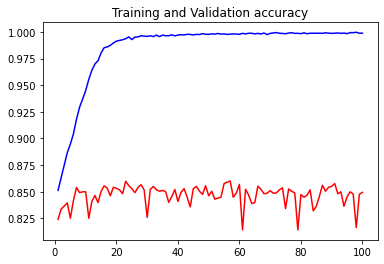

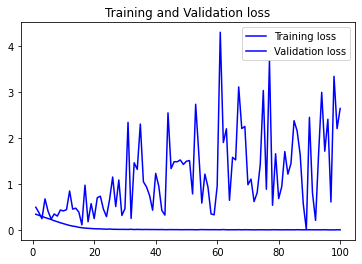

In [24]:
import matplotlib.pyplot as plt


acc = histroy.history['acc']
val_acc = histroy.history['val_acc']
loss = histroy.history['loss']
val_loss = histroy.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

#모델 테스트


In [0]:
from keras import preprocessing

img = preprocessing.image.load_img(
    "test/test_Cat/6779.jpg", target_size=target_size
)
img_array = preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis



In [0]:
img_array = preprocessing.image.img_to_array(img)


In [36]:
np.shape(img_array)

TensorShape([1, 150, 150, 3])

In [0]:
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [0]:
img_array

In [37]:
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

ValueError: ignored